This notebook explores the basics of Reinforcement learning after attending the RL workshop

First the recommended How to apply? [Tabular Q-learning with Gym tutorial](https://towardsdatascience.com/reinforcement-learning-with-openai-d445c2c687d2) is followed.  
NOTE: This blog post is not followed exactly, as it leaves out some very usefull information, has outdated code examples, and performs some very situationally dependant actions which does not work well when copying the steps taken over

Lets view all our installed environments

In [6]:
from gym import envs 
print(envs.registry.keys())

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4'])


Next lets render an environment, and perform random actions by sampling a random action from the action space, then the given action is perfomed within the environment.  
Performing actions within the environment returns information about the action and environment including a terminated value, when this is True the model has been able to complete the environment goal.

In [15]:
import gym
env = gym.make('MountainCarContinuous-v0')
observation = env.reset()
i = 0
while True:
    i += 1
    env.render()
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated:
        print("Finished after {} timesteps".format(i+1))
        break

c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\classic_control\continuous_mountain_car.py:193: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("MountainCarContinuous-v0", render_mode="rgb_array")
  gym.logger.warn(


Finished after 3259 timesteps


In [17]:
env = gym.make('MountainCarContinuous-v0')
print(env.action_space) #[Output: ] Box(1,)
print(env.observation_space) #[Output: ] Box(2,)

Box(-1.0, 1.0, (1,), float32)
Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


The MountainCarContinuous-v0 has a single action space value, indicating the force applied in the x-axis (negative being left and positive being right),
while the observation space shows two values, which to my knowledge indicate the position and velocity
documentation on [this env](https://mgoulao.github.io/gym-docs/environments/classic_control/mountain_car_continuous/#observation-space)

Next lets start working within the FrozenLake environment, for this additional environments had to be installed, which would have caused issues with box2d-py, but thankfully I have an older version of pip which still supports the legacy installer allowing me to install it via there automatically (pip=23.0.1, legacy installer no longer supported from pip=23.1)

Frozen lake is an environment which a 2d grid, on this grid there is a goal space, and some danger spaces that the actor has to navigate through.  
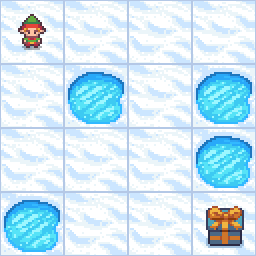

The first step of the model will be the Q-table, this table contains the actions for a given state whith the rewards that action is expected to give (this can also be seen as a representation for the quality of an action), this table will start off with random values, and through iterating over the environment, the Q-table can be refined based on the findings.

In [45]:
import gym
import numpy as np
env = gym.make('FrozenLake-v1', render_mode='rgb_array', map_name='4x4') # Frozen lake of 4x4 size <- human renderer shows game visually in pop_up, but ruins performance
Q = np.zeros([env.observation_space.n, env.action_space.n]) # env.observation.n, env.action_space.n gives number of states and action in env loaded
# The table will look something like
# | State | Action: Up | Action: Down | Action: Left | Action: Right |
# |-------|------------|--------------|--------------|---------------|
# |   0   |   0.2      |   0.1        |   0.3        |   0.5         |
# | etc.                                                             |

# Set the hyper parameters
eta = .628 # Learning rate
gma = .9 # discount factor, determining how far in the future the agent should consider
iterations = 1000000 # amount of "episodes, or iterations of the model

total_rewards = []
total_steps = []
success_rate = []
for i in range(iterations):
    state = env.reset()[0] # Setup a fresh environment
    episode_reward = 0
    step = 0
    while True: # Start stepping through the environment to obtain Q values to help improve the table
        step += 1
        # env.render()
        # action = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i+1))) # Choose a random action from the Q table
        # A random action is obtained greedily, by first getting all actions within the current state, 
        # Obtain a list of random indexes within the possible range of actions <- this adds the exploration, so that the model does not get stuck in a local minimum of highest reward
        # next this value is multiplied by a decreasing value based on episode count, thereby reducing the amount of exploration as the training continues
        # lastyle, the greediest action is chosen from the adjusted list of actions based on highest reward 
        
        # to make this more readable I have changed it to a conditional function instead
        explorationChance = 1.0 / (i + 1)
        if np.random.rand() < explorationChance:
            action = env.action_space.sample() # Explore, by getting a random action
        else:
            action = np.argmax(Q[state, :]) # Exploit, by getting the best action

        # Get new state & reward from environment
        observation, reward, terminated, truncated, info = env.step(action) # perform the action
        Q[state, action] = Q[state, action] + eta*(reward + gma*np.max(Q[observation,:]) - Q[state, action]) # Update Q-Table with the action result
        # The new reward for given state and action is calculated by first, calculate the maxiumum expected reward from given action, taking into account future actions (based on gma)
        # This maximum possible value is then subtracted from with the current value, to get the possible gain
        # then the possible gain is added to the current value, reducing the possible gain first by eta
        episode_reward += reward
        state = observation # Update the state for next step
        if terminated:
            break # Environment was terminated, either by reaching the goal or falling in a hole

    total_rewards.append(episode_reward)
    total_steps.append(step)
    success_rate.append(int(episode_reward > 0))
    # env.render()
env.close()
print(f"Success rate (%) over {iterations} episodes: {str(np.mean(success_rate) * 100)}")

Success rate (%) over 1000000 episodes: 0.0


Above I have set-up a Q-table learning model that will step through the frozen lake environment and update the Q-table based on the rewards gained, this model is very slow at learning however due to the agent only getting a reward when reaching the goal, which can take 100s if not 1000s of iterations before even reaching it once.  
When training the model with 100.000 episodes, only sometimes would there be even a single successful episode, while with 1 million episodes it was still at 0 D:

Below a plot of the rewards over the episodes

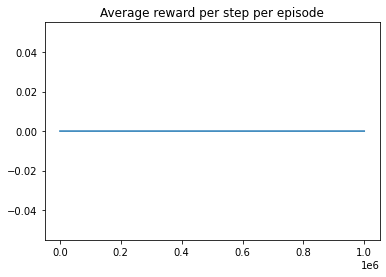

In [47]:
import matplotlib.pyplot as plt

average_reward_per_step = [reward / steps for reward, steps in zip(total_rewards, total_steps)]

plt.plot(average_reward_per_step)
plt.title("Average reward per step per episode")

plt.show()

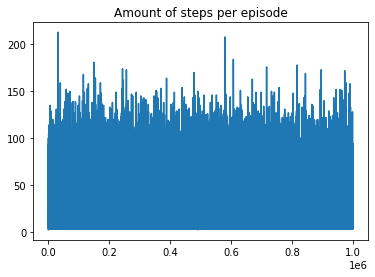

In [48]:
plt.plot(total_steps)
plt.title("Amount of steps per episode")

plt.show()

The agent is really just walking around for 100-200 steps, just to fall in a hole for a million times... (did I put this model in AI hell?)

**Emeregency close of any running environment if code cell is interrupted, as otherwise it will kill the python kernel**

In [123]:
env.close()

: 

Next I will be looking at the [Keras ANN Q-learning example](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c)

In [2]:
import gym
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from collections import deque

First lets create a class that holds all of the required DQN definitions

In [3]:
class DQN:
    def __init__(self, env, gamma = 0.85, epsilon_decay = 0.995, eta = 0.005, tau = .125, history_batch_size = 32):
        self.env = env # gym environment
        self.memory = deque(maxlen=1000) # maximum memory of 2000, a random selection will be made of the memory when evaluating actions
        
        self.gamma = gamma # future discount factor
        self.epsilon = 1.0 # exploration vs exploitation
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.eta = eta # learning rate
        self.tau = tau # model weight adjustment rate for target model
        self.history_batch_size = history_batch_size # Amount of history states to replay

        self.model = self.create_model() # The model used for training and is updated rapidly
        self.target_model = self.create_model() # The model t|hat updates less often, used to give actions to the current episode

    def create_model(self):
        # Create the ANN model that will handle the action choice 
        model = Sequential()
        state_shape = self.env.observation_space.shape
        model.add(Dense(state_shape[0], input_dim=state_shape[0], activation="relu"))
        model.add(Dense(512, activation="relu"))
        model.add(Dense(256, activation="relu"))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=self.eta))
        return model

    def action(self, state):
        # Choose an action to take from the more stable weighted model
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample() # Exlore a random action
        predicted_action = self.model.predict(np.array(state, dtype=np.float32), verbose=0)
        return np.argmax(predicted_action[0]) # Greedily select action

    def remember(self, state, action, reward, new_state, done):
        # Add action results to the model memory
        self.memory.append([np.array(state, dtype=np.float32), action, reward, new_state, done])

    def replay(self):
        # Attempt to improve weights of model by replaying the model's memory (this is scarily similar to what is presumed to happen during REM sleep...)
        if len(self.memory) < self.history_batch_size: 
            return

        samples = random.sample(self.memory, self.history_batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(np.array(state, dtype=np.float32), verbose=0)
            if done:
                target[0][action] = reward # If state is terminated, set the Q-value to be the reward value
            else:
                Q_future = max(self.target_model.predict(new_state, verbose=0)[0]) # Calculate the Q-value based on future steps
                target[0][action] = reward + Q_future * self.gamma
            self.model.fit(state, target, epochs=1, verbose=0)

    def target_train(self):
        # Update the weights of the action giving model,
        # This model's weights are adjusted less often to reduce the amount of entropy experienced when having a model predict actions with rapidly changing weights
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)
    
    def save(self, path):
        self.target_model.save(f"models/{path}/target_model/")
        self.model.save(f"models/{path}/model/")

    def update_epsilon(self):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)


In [5]:
env = gym.make("MountainCar-v0")
episodes = 5
max_steps = 100

total_steps = []

agent = DQN(env=env)
for episode in range(episodes):
    print(f"episode: {episode}")
    cur_state = [list(env.reset()[0])] # Get initial state of the reset environment
    first_step = True
    for step in range(max_steps):
        action = agent.action(cur_state) # Get action for current state
        new_state, reward, terminated, truncated, debug = env.step(action) # Perform the action
        new_state = new_state.reshape(1,2)
            
        agent.remember(cur_state, action, reward, new_state, terminated) # Store the performed action for given state and result in models memory
        
        agent.replay() # replay the memory of the model to adjust Q-table (weights) <- this kills performance
        agent.target_train() # adjust the target Q-table based on difference and learning rate of the two model's weights

        cur_state = new_state
        if terminated:
            total_steps.append(step)
            break # environment terminated

2023-10-25 23:54:30.424642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 23:54:30.449351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 23:54:30.449392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 23:54:30.451983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 23:54:30.452025: I tensorflow/compile

episode: 0


2023-10-25 23:54:31.612093: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-25 23:54:32.751144: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa1a0005fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-25 23:54:32.751192: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-10-25 23:54:32.758386: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-25 23:54:32.783397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-25 23:54:32.879733: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


episode: 1
episode: 2
episode: 3
episode: 4


Lets implement GPU support for tensorflow, because the constant training of the ANN is making the model extremely slow (15 minutes+ per episode)

In [1]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [2]:
tf.config.list_physical_devices('GPU')

[]

As you can see, right now I have v 2.14.0 of tensorflow, and there are no avaible GPUs, while I do have a GTX 1070 in this PC,  
the GTX 1070 (unlike my GTX 1650 in my laptop D:) is CUDA-Enabled according to the [NVidia support list](https://developer.nvidia.com/cuda-gpus), also make sure the newest drivers for the given graphics card are installed (I have already done this, as it is generally best practise to keep them up-to-date).  
   
Next, install the [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit-archive) in accordance to the version [supported by tensorflow](https://www.tensorflow.org/install/source) which in this case is 11.8,  
   
and lastly install the [cuDNN SDK](https://developer.nvidia.com/cudnn) which will extend the CUDA Toolkit, once again make sure it is the version that the installed tensorflow version supports. (After downloading the SDK, move the files into the toolkit directory which after some looking around turned out to be here: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8).

Now that the windows GPU side is done, lets set-up WSL2, as TF>2.18 no longer has native windows support >:(  
First step will be to install [WSL2](https://learn.microsoft.com/en-us/windows/wsl/install) thankfully I have already done that.  
  
Next setup GPU support in WSL2, this can best be done via the [NVidia getting started guide](https://docs.nvidia.com/cuda/wsl-user-guide/index.html#getting-started-with-cuda-on-wsl-2), via this guide the CUDA toolkit will also be installed on the WSL2 client for the specific GPU.  
(NOTE: Make sure to install cuda toolkit version has mentioned before (11.8) as the guide might not indicate the correct version!!!)
  
After this, pip and tensorflow can be installed (make sure that when you try to access the wsl, you have the correct distro selected as for me it kept giving errors due to my Docker instance being set as the default).

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-10-25 23:23:42.732993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 23:23:42.733047: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 23:23:42.733068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 23:23:42.738794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 23:23:44.494920: I tensorflow/compiler/

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

So 'Technically' yes, I am now running the notebook through WSL2 with TF able the access my GPU, however it throws a lot of warnings both in just this function example to check if it can find my GPU, and even more when modelling (most of these warnings seem to be about the kernel not supporting NUMA, which *should* be fine according to some discussion threads out there...).

Sadly, my GPU does not seem to help much with the extremely intesive ANN RL model attempted with Mountain car, as episodes still take significantly too long

However, I would still like to do a third attempt, now that I have gained a much clearer understanding of RL and gym and have the power of a GTX 1070 in the palm of my hand.  
So, lets try out the LunarLander environment, this environment seems to be gym's favorite as it is referenced and used as an example everywhere.  
To get box2d installed (the kit that contains the LunarLander environment), I had to first install swig on my WSL2 kernel.

First I will try out a simple completely random non-learning RL model in the LunarLander environment to see how it all works

In [5]:
import gym
try:
   env = gym.make("LunarLander-v2", render_mode="human")
   observation, info = env.reset(seed=42)
   for _ in range(1000):
      action = env.action_space.sample()
      observation, reward, terminated, truncated, info = env.step(action)

      if terminated or truncated:
         observation, info = env.reset()
finally:
   env.close()

/home/thomas/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


The LunarLander environment has four actions within it's action space:
- do nothing
- fire left (go right)
- fire right (go left)
- fire primary (upwards)

And 8 features in observation space:
- x position
- y position
- x velocity
- y velocity
- angle (rotation)
- anglular velocity (rotation speed)
- is_left_leg_on_ground
- is_right_leg_on_ground

If the lander crashes it will lose 100 points, alongside a -0.3 and -0.03 points per frame the main or side engine is firing respectively.  
If the lander lands on the ground it gets 100 points with a bonus 10 points for each leg on the ground,  
the [documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/#rewards) on the rewards is worded quite confusingly but I assume extra points are given if landing within the landing zone, or the landing on the ground might only count when it is in the zone.

The observation space for the LunarLander are continuous, this means a simple Q-table as done with FrozenLake will not inherintly work (infinite possible states), this could be solved by undersampling the continuous values (rounding to a whole value for example for a given range), however this is kind of a work around and there are much smarter solutions out there such as using a deep learning model, just as was done for the MountainCar 

To help me get a better understanding of a possible implementation of thise (better than the mountain car), I want to credit [this amazing project](https://xusophia.github.io/DataSciFinalProj/), which goes fairly deep into many different possible solutions, with even more advanced research papers attached.

In [4]:
import gym
import numpy as np
env = gym.make("LunarLander-v2", render_mode="human")
episodes = 500
max_steps = 200

total_steps = []
total_rewards = []

try:
    agent = DQN(env=env)
    for episode in range(episodes):
        print(f"episode: {episode}")
        state, info = env.reset() # Get initial state of the reset environment
        state = state.reshape(1, 8)
        steps_taken = 0
        reward_score = 0
        for step in range(max_steps):
            steps_taken += 1
            action = agent.action(state) # Get action for current state
            new_state, reward, terminated, truncated, debug = env.step(action) # Perform the action
            new_state = new_state.reshape(1,8)

            reward_score += reward

            if terminated or truncated: # Check if action caused environment to end
                total_steps.append(step)
                break # environment terminated so current episode should finish
                
            agent.remember(state, action, reward, new_state, terminated) # Store the performed action for given state and result in models memory

            state = new_state # Set new state as current state (go to the next frame)
        total_steps.append(steps_taken)
        total_rewards.append(reward_score)
            
        agent.target_train() # adjust the target Q-table based on difference and learning rate of the two model's weights
        agent.replay() # replay the memory of the model to adjust Q-table (weights) <- this kills performance
    agent.save() # Store model for reuse
finally:
    env.close()

episode: 0
episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
episode: 51
episode: 52
episode: 53
episode: 54
episode: 55
episode: 56
episode: 57
episode: 58
episode: 59
episode: 60
episode: 61
episode: 62
episode: 63
episode: 64
episode: 65
episode: 66
episode: 67
episode: 68
episode: 69
episode: 70
episode: 71
episode: 72
episode: 73
episode: 74
episode: 75
episode: 76
episode: 77
episode: 78
episode: 79
episode: 80
episode: 81
episode: 82
episode: 83
ep

INFO:tensorflow:Assets written to: models/target_model/assets


INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


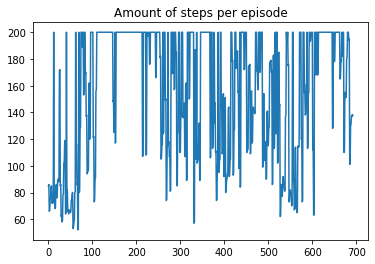

In [7]:
import matplotlib.pyplot as plt
plt.plot(total_steps)
plt.title("Amount of steps per episode")

plt.show()

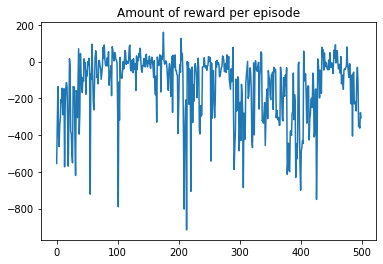

In [8]:
plt.plot(total_rewards)
plt.title("Amount of reward per episode")

plt.show()

In the model above, I am using two models that should learn from eachother, thereby avoiding possible issues that could occur while using a single model, such as overestimating reward actions.
In this current attempt, I am only updating the model after the episode has finished, thereby it is only learning between episodes (as is often the case in more simple systems), I have tried looking around to find out the best way of implementing this kind of model, and it seems to most people either update the model every step, or every couple steps, this is however extremely computationally intesive and the reason why my previous model become untrainable for me.  

Running this model gave very interesting results however, as the model actually did seem to learn, but not what is intended (this knowledge is obtained from looking at the results and observing the model during training as human vs rgb rendering did not seem to have a big performance difference). The model seems to have learned how to keep the lander upright (no rotation) as this avoid crashing and thereby loosing a bunch of points, but did not seem to learn to actually land to gain the extra points.  
This behavior is a clear example of being more exploitive than explorative and could be adjusted for by increasing the epsilon_decay value, thereby slowing the rate of explotation and performing more random actions.

In the next part I will be training a fresh model again as the previous model does not show any significant improvement past the first ~50 episodes, where I will be messing around with the hyperparameters to see how that effects the score.  
NOTE: 200 reward is the target max possible reward

In [23]:
import gym
import numpy as np
def LunarLander(decay_rate, episodes, max_steps):
    env = gym.make("LunarLander-v2")

    total_steps = []
    total_rewards = []
    info_results = [[]]

    try:
        agent = DQN(env=env, epsilon_decay=decay_rate)
        for episode in range(episodes):
            print(f"episode: {episode}")
            state, info = env.reset() # Get initial state of the reset environment
            state = state.reshape(1, 8)
            steps_taken = 0
            reward_score = 0
            for step in range(max_steps):
                steps_taken += 1
                action = agent.action(state) # Get action for current state
                new_state, reward, terminated, truncated, debug = env.step(action) # Perform the action
                new_state = new_state.reshape(1,8)

                reward_score += reward

                info_results[episode].append(debug) # add the debug info to look at later
                if terminated or truncated: # Check if action caused environment to end
                    break # environment terminated so current episode should finish
                    
                agent.remember(state, action, reward, new_state, terminated) # Store the performed action for given state and result in models memory

                state = new_state # Set new state as current state (go to the next frame)
            total_steps.append(steps_taken)
            total_rewards.append(reward_score)
                
            agent.target_train() # adjust the target Q-table based on difference and learning rate of the two model's weights
            agent.replay() # replay the memory of the model to adjust Q-table (weights) <- this kills performance
        agent.save("artifacts") # Store model for reuse
    finally:
        print("finished")
        env.close()
        return total_steps, total_rewards, info_results

In [24]:
steps_results, rewards_results, debug = LunarLander(0.85, 150, 200)

episode: 0
episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
episode: 51
episode: 52
episode: 53
episode: 54
episode: 55
episode: 56
episode: 57
episode: 58
episode: 59
episode: 60
episode: 61
episode: 62
episode: 63
episode: 64
episode: 65
episode: 66
episode: 67
episode: 68
episode: 69
episode: 70
episode: 71
episode: 72
episode: 73
episode: 74
episode: 75
episode: 76
episode: 77
episode: 78
episode: 79
episode: 80
episode: 81
episode: 82
episode: 83
ep

INFO:tensorflow:Assets written to: models/artifacts/target_model/assets


INFO:tensorflow:Assets written to: models/artifactsmodel/assets


INFO:tensorflow:Assets written to: models/artifactsmodel/assets


finished


This model has a far lower epsilon decay, meaning that it will much faster that exploiting its knowledge than exploring, this "should" make the model worse when compared to the previous model, but should allow us to see it plateau on a given amount of rewards earned as it stops trying to expirement to gain higher scores

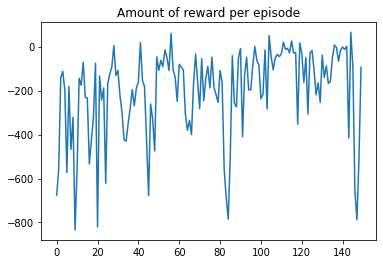

In [25]:
plt.plot(rewards_results)
plt.title("Amount of reward per episode")

plt.show()

Due to the limited amount of episodes, however it is very unconclusive if the model actually learned something to start basing its actions on in the first place, meaning that eventho it might have started exploiting more, the exploitation actions were very poor (as expected) or the actions might as well have been random due to the low level of convergence onto a good strategy

Further considering the fact that the previous (larger 500 episode model) started what seemed to be hovering in the air to minimize the possible loss from crashing, not considering the possible massive gain from landing, might actually not exclusively be because it started exploiting too early, but could indicate that the amount of steps per episode was too small making the risk of negative reward not big enough (as hovering can only cost as many points as the amount of steps the episode lasts).

Lets actually try training the model with default parameters again, but this time make the episode last as long as necessary.

In [33]:
import gym
import numpy as np
def LunarLanderEndless(episodes, epsilon_decay = 0.995, rendering="human"):
    env = gym.make("LunarLander-v2", render_mode=rendering)

    total_steps = []
    total_rewards = []
    info_results = [[]]

    try:
        agent = DQN(env=env, epsilon_decay=epsilon_decay)
        for episode in range(episodes):
            print(f"episode: {episode}")
            state, info = env.reset() # Get initial state of the reset environment
            state = state.reshape(1, 8)
            steps_taken = 0
            reward_score = 0
            while True:
                steps_taken += 1
                action = agent.action(state) # Get action for current state
                new_state, reward, terminated, truncated, debug = env.step(action) # Perform the action
                new_state = new_state.reshape(1,8)

                reward_score += reward

                # info_results[episode].append(debug) # add the debug info to look at later
                if terminated or truncated: # Check if action caused environment to end
                    break # environment terminated so current episode should finish
                    
                agent.remember(state, action, reward, new_state, terminated) # Store the performed action for given state and result in models memory

                state = new_state # Set new state as current state (go to the next frame)
            total_steps.append(steps_taken)
            total_rewards.append(reward_score)
                
            agent.update_epsilon() # Update the epsilon parameter based on epsilon_decay <- added later
            agent.target_train() # adjust the target Q-table based on difference and learning rate of the two model's weights
            agent.replay() # replay the memory of the model to adjust Q-table (weights) <- this kills performance
    except Exception as e:
        print(f"An exception occured: {e}")
    finally:
        agent.save("endless") # Store model for reuse
        print("finished")
        env.close()
        return total_steps, total_rewards, info_results

In [8]:
endless_steps_total, endless_rewards_total, endless_debug = LunarLanderEndless(500)

episode: 0
episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
episode: 51
episode: 52
episode: 53
episode: 54
episode: 55
episode: 56
episode: 57
episode: 58
episode: 59
episode: 60
episode: 61
episode: 62
episode: 63
episode: 64
episode: 65
episode: 66
episode: 67
episode: 68
episode: 69
episode: 70
episode: 71
episode: 72
episode: 73
episode: 74
episode: 75
episode: 76
episode: 77
episode: 78
episode: 79
episode: 80
episode: 81
episode: 82
episode: 83
ep

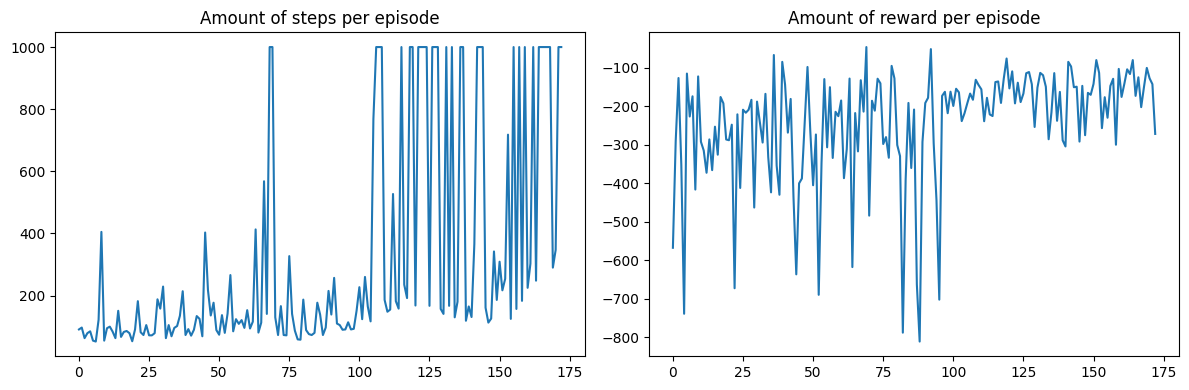

In [9]:
import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# First subplot (total_steps)
axes[0].plot(endless_steps_total)
axes[0].set_title("Amount of steps per episode")

# Second subplot (total_rewards)
axes[1].plot(endless_rewards_total)
axes[1].set_title("Amount of reward per episode")

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plots
plt.show()


I ended up stopping the training before 500 episodes (175 episodes) and it actually seemed to have done the same as before, where it learned to minimize loss by hovering around (which caused the episodes to become significantly longer).

After thinking more about the behavior of the model I noticed that my epsilon decay update might be happening too often, as it is currently updated on every action, meaning the epsilon value decreases every step, this might cause the model to switch far too quickly to exploitation than intended

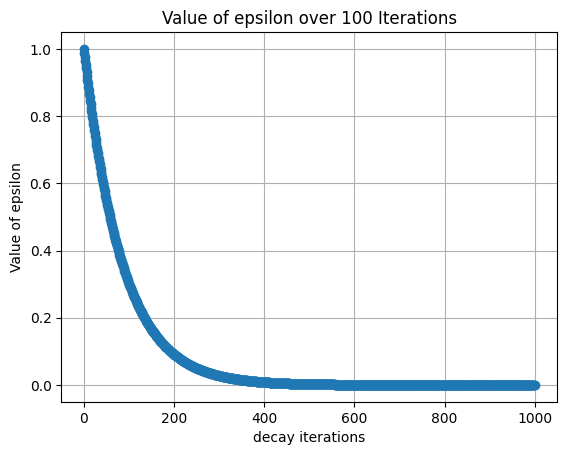

In [30]:
import matplotlib.pyplot as plt

epsilon = 1
iterations = 1000
epsilon_values = [epsilon]

for i in range(iterations):
    epsilon *= 0.9880885802850193 
    epsilon_values.append(epsilon)

iteration_numbers = list(range(iterations + 1))

plt.plot(iteration_numbers, epsilon_values, marker='o', linestyle='-')

plt.xlabel("decay iterations")
plt.ylabel("Value of epsilon")
plt.title("Value of epsilon over 100 Iterations")

plt.grid(True)
plt.show()


As shown, after around 1000 iterations with a decay of 0.995, the epsilon value is virtually 0, meaning the model has started to only perform based on its internal Q values,  
if I want to change to decay per episode, I would like this point to be reached somewhere near my final episode.

In [29]:
# Desired final value for epsilon
final_epsilon = 0.05

# Number of iterations to reach the final value
iterations = 250

# Calculate epsilon_decay
epsilon_decay = (final_epsilon / 1) ** (1 / iterations)

print("Epsilon Decay Value:", epsilon_decay, "for", iterations, "iterations")


Epsilon Decay Value: 0.9880885802850193 for 250 iterations


In the next training phase, I have moved the epsilon_decay update to every episode instead of every step

In [35]:
endless_steps_total, endless_rewards_total, endless_debug = LunarLanderEndless(250, epsilon_decay=0.9880885802850193, rendering="rgb_array")

episode: 0


c:\Users\Thomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
episode: 51
episode: 52
episode: 53
episode: 54
episode: 55
episode: 56
episode: 57
episode: 58
episode: 59
episode: 60
episode: 61
episode: 62
episode: 63
episode: 64
episode: 65
episode: 66
episode: 67
episode: 68
episode: 69
episode: 70
episode: 71
episode: 72
episode: 73
episode: 74
episode: 75
episode: 76
episode: 77
episode: 78
episode: 79
episode: 80
episode: 81
episode: 82
episode: 83
episode: 84
e

INFO:tensorflow:Assets written to: models/endless/target_model/assets


INFO:tensorflow:Assets written to: models/endless/model/assets


INFO:tensorflow:Assets written to: models/endless/model/assets


finished


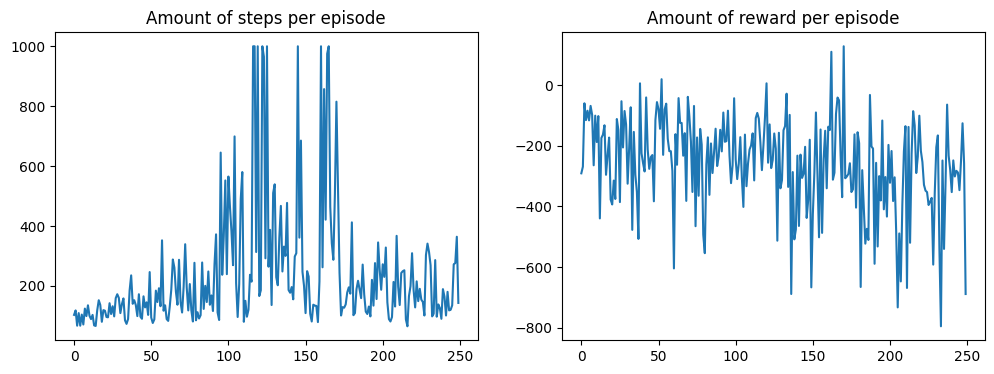

In [36]:
import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# First subplot (total_steps)
axes[0].plot(endless_steps_total)
axes[0].set_title("Amount of steps per episode")

# Second subplot (total_rewards)
axes[1].plot(endless_rewards_total)
axes[1].set_title("Amount of reward per episode")

# Show the plots
plt.show()


After training the agent for an afternoon my VSCode ended up crashing without running the exception path, causing all progress for that model to be lossed, so I had decided to train the model again but with only 250 episodes (still taking close to 2 hours), from the results above however, the model did not really seem to improve over time, there is a very interesting increase in stepss towards the middle of training phase, possibly as the agent got caught in the local minimum of hovering the air to reduce amount of points lost from crashing as the previous model had found out and got stuck on, but this phase seems to have ended nearing the 200 episodes.  
Note that between 50-100 episodes the model had switched from random actions to using the ANN as the primary action predictor, this does sort of line up with when the model started exploiting its knowledge of hover.

After discussing with some other students, I have decided to give Frozen-lake another shot, possibly ending up creating my own frozen lake environment that gives better rewards

As a sanity check, I will first follow this [different tutorial for frozen lake using Q learning](https://towardsdatascience.com/q-learning-for-beginners-2837b777741)

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Q-table after training:
[[0.         0.         0.00631894 0.        ]
 [0.         0.00077252 0.         0.        ]
 [0.         0.         0.         0.00155912]
 [0.00069416 0.         0.         0.        ]
 [0.         0.         0.0059888  0.        ]
 [0.         0.         0.         0.        ]
 [0.0008716  0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.04713434 0.        ]
 [0.0253206  0.         0.         0.        ]
 [0.12164064 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.5238535  0.        ]
 [0.         0.         0.49585571 0.        ]
 [0.

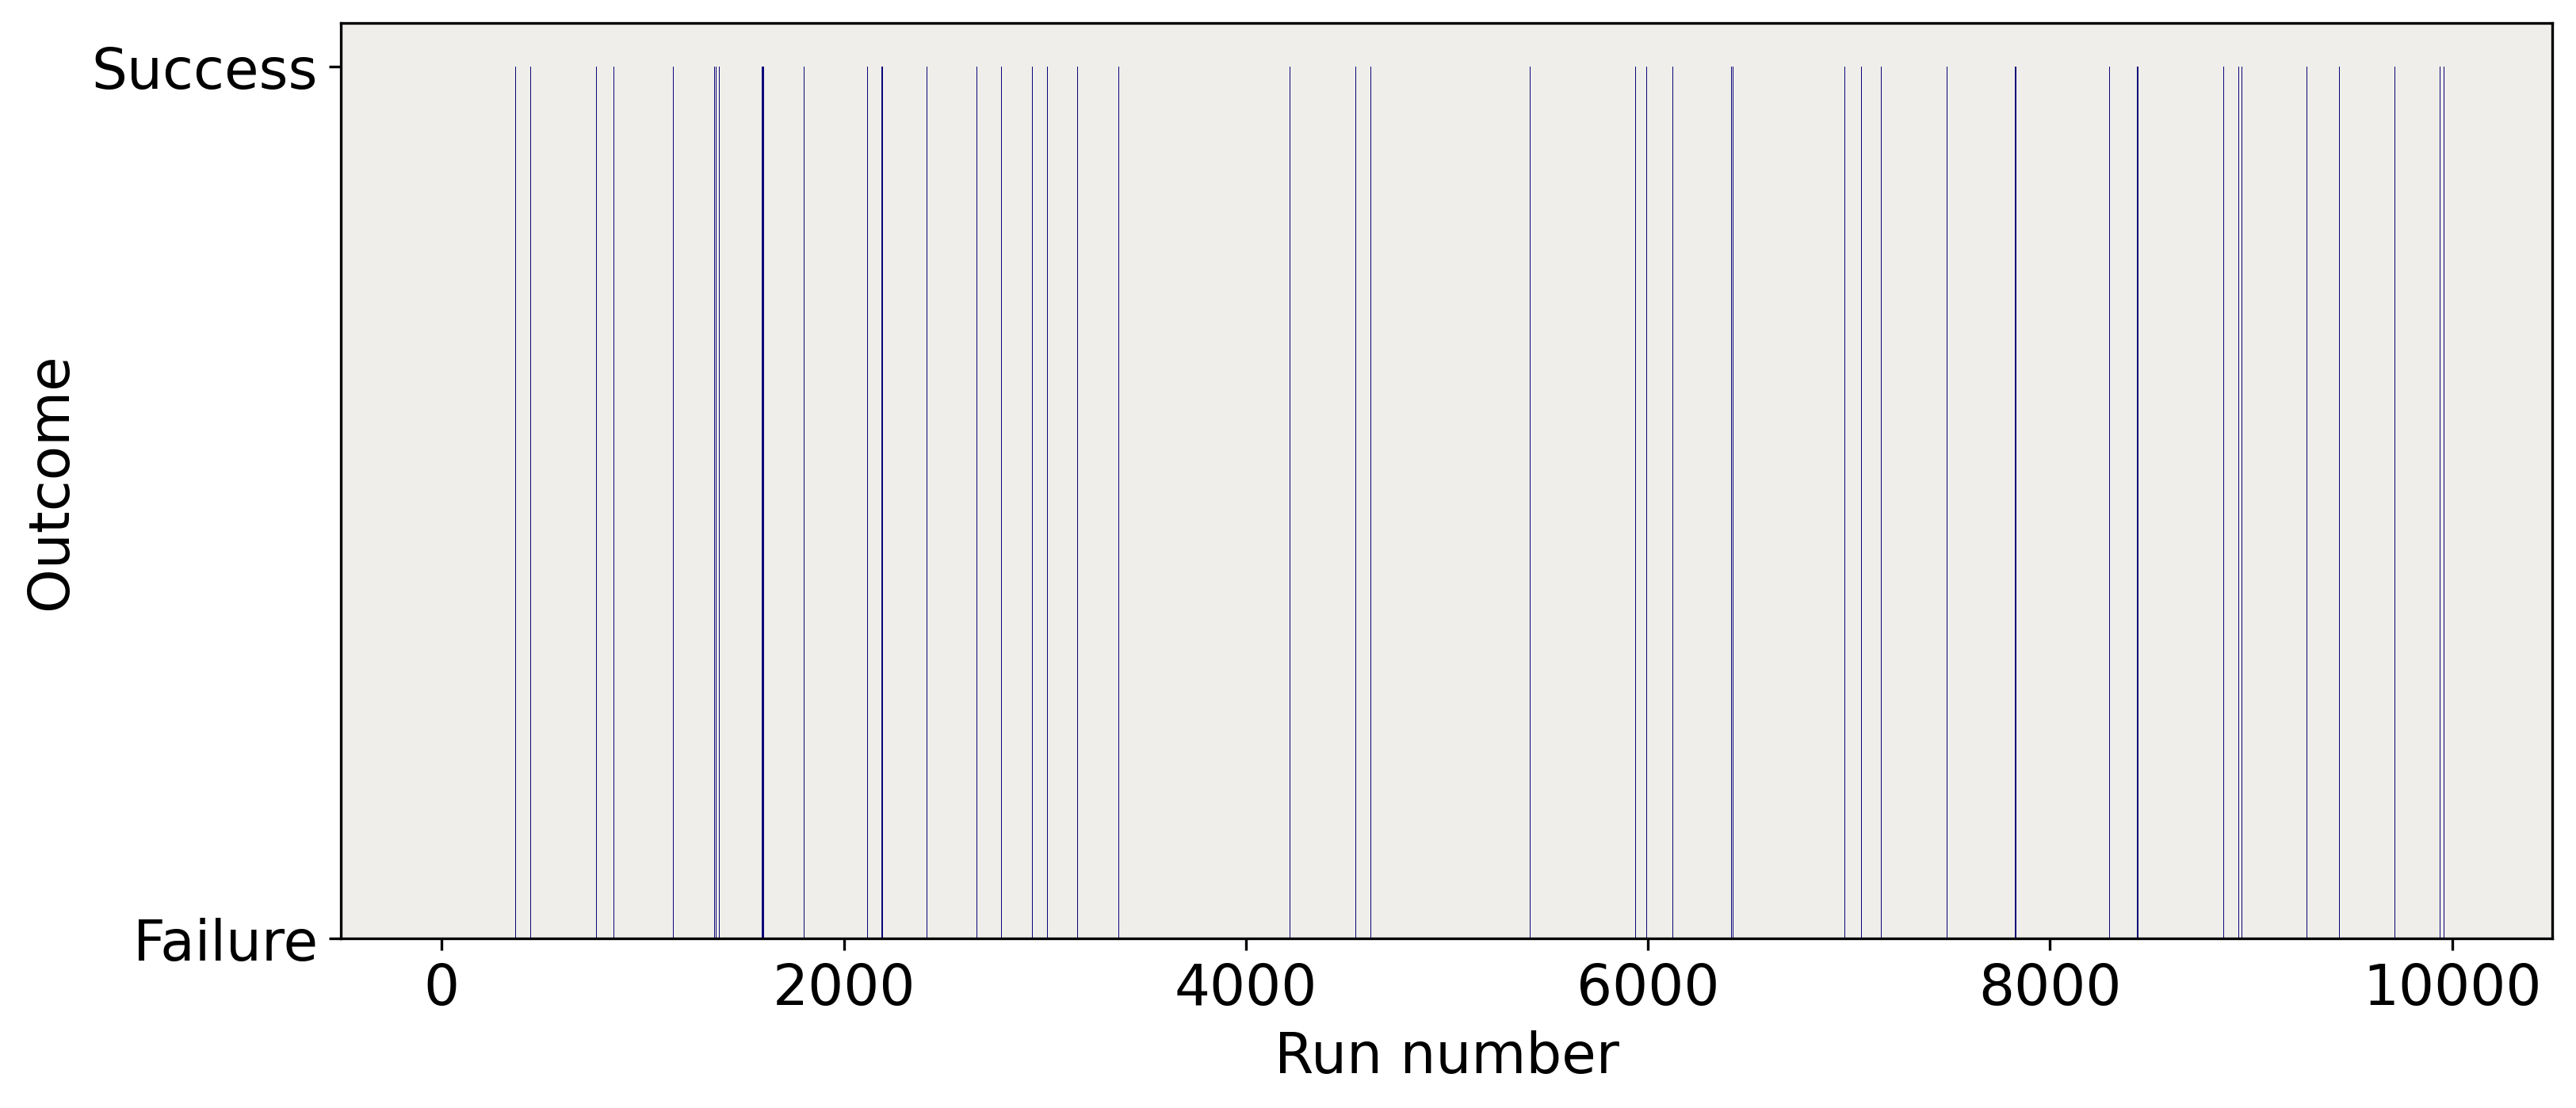

In [10]:
import matplotlib.pyplot as plt
import gym
import numpy as np

env = gym.make('FrozenLake-v1', render_mode='rgb_array', map_name='4x4')

# We re-initialize the Q-table
qtable = np.zeros((env.observation_space.n, env.action_space.n))

# Hyperparameters
episodes = 10000       # Total number of episodes
alpha = 0.5            # Learning rate
gamma = 0.9            # Discount factor

# List of outcomes to plot
outcomes = []

print('Q-table before training:')
print(qtable)

# Training
try:
  for _ in range(episodes):
      state, info = env.reset()
      done = False

      # By default, we consider our outcome to be a failure
      outcomes.append("Failure")

      # Until the agent gets stuck in a hole or reaches the goal, keep training it
      while not done:
          # Choose the action with the highest value in the current state
          if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

          # If there's no best action (only zeros), take a random one
          else:
            action = env.action_space.sample()
              
          # Implement this action and move the agent in the desired direction
          new_state, reward, terminated, truncated, info = env.step(action)

          done = terminated or truncated
          # Update Q(s,a)
          qtable[state, action] = qtable[state, action] + alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
          
          # Update our current state
          state = new_state

          # If we have a reward, it means that our outcome is a success
          if reward:
            outcomes[-1] = "Success"
finally:
   env.close()

print()
print('===========================================')
print('Q-table after training:')
print(qtable)

# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show()

As a sanity check, this has done the complete opposite of give me more sanity, it has in fact confused me more by actually behaving as I expected my previous attempt to work (granted this one uses a greedy approach of always selection the highest Q value action from the current Q-table)